In [1]:
# 09/03/2020 nadanai.laohakunakorn@ed.ac.uk

# readPlate

# Read plate reader data from Excel file and output a reduced Excel file 
# containing just the timeseries data.

# This notebook can be run directly in colab: drag the notebook file into colab, and 
# upload the data file '*.xlsx' to the same directory. 

# Alternatively you can run this locally, using Anaconda or another virtual environment. 
# Again, just make sure the data file is in the same directory.

# Tested with 
# python 3.6, python 3.7, python 3.8
# numpy 1.17.2
# matplotlib 2.1.1
# pandas 0.23.4
# xlrd 1.2.0
# xlwt 1.3.0

In [2]:
# 0. Set up packages we need

# Import everything:
import numpy as np # Maths functions, matrices 
import matplotlib.pyplot as plt # Plotting
import pandas as pd # Dataframes, which are more advanced arrays, useful for storing and manipulating data

In [3]:
# Parameters which must be set before running code go here:

NUMBER_OF_WELLS = 16
INPUT_FILE = './raw_data/NL_GFP_plate_19-02.xlsx'
OUTPUT_FILE = './reduced_data/reduced_data.xlsx'

In [4]:
# 1. READ DATA FROM FILE
# Read our excel file into a variable called 'xls'
# The function ExcelFile() comes from the pandas package
# It takes as an argument the path to the data file; './' is the current directory
# If you get an error here you might have to install the package xlrd ('Excel read')
# using the command: pip3 install xlrd

xls = pd.ExcelFile(INPUT_FILE)
df = pd.read_excel(xls)

# 2. GET DATA INTO DATAFRAMES
# Find where data blocks are
chromatic_start_indices = df[df.iloc[:,0].str.contains('Chromatic', na=False) == True].index.tolist()
number_of_chromatics = len(chromatic_start_indices)

# Get temp indices
temp_start_indices = [idx+5 for idx in chromatic_start_indices]

# Get chromatic settings
chromatic_start_ID = df[df.iloc[:,0].str.contains('Used filters', na=False) == True].index.tolist()
chromatic_IDs = []
for i in range(number_of_chromatics):
    chromatic_IDs.append(df.iloc[chromatic_start_ID[0]+1+i,0])
chromatic_IDs = [ID.lstrip()[3:] for ID in chromatic_IDs] # Clean up chromatic names

# We will put each chromatic into a separate dataframe
# and store the dataframes in a python dictionary

data_dict = {}

# For each chromatic, extract data
for i in range(len(chromatic_IDs)):

    df1=pd.DataFrame(index=None)
    df1['Time (s)'] = df.iloc[chromatic_start_indices[i]+3,:]
    df1['Temp (*C)'] = df.iloc[temp_start_indices[i],:]

    # Get data indices
    data_indices = np.arange(temp_start_indices[i]+1,temp_start_indices[i]+NUMBER_OF_WELLS+1).tolist()

    # Extract well IDs from first column
    initial_values = df.iloc[data_indices,0].tolist()
    headers = [head[:3] for head in initial_values]
    initial_data = [int(datum[4:]) for datum in initial_values]

    # Then strip first column, editing original df
    for j in range(NUMBER_OF_WELLS):
        df.iloc[data_indices[j],0]=initial_data[j]

    # Write all data
    for j in range(NUMBER_OF_WELLS):
        df1[headers[j]]=df.iloc[data_indices[j],:]

    df1=df1.reset_index(drop=True)   
    
    data_dict[chromatic_IDs[i]] = df1
    
# 3. SAVE DATA TO NEW EXCEL FILE
# Finally let's save our dataframe to a new file
# If you get an error here you might have to install the package xlwt ('Excel write') 
# and openpyxl
# using the command: pip3 install xlwt openpyxl

with pd.ExcelWriter(OUTPUT_FILE) as WRITER:
    for i in range(len(chromatic_IDs)):
        data_dict[chromatic_IDs[i]].to_excel(WRITER, sheet_name='Sheet '+str(i))

In [5]:
# How to use the reduced file

# 1. Read file
xls = pd.ExcelFile(OUTPUT_FILE)
# 2. Select sheet and put into dataframe
df = pd.read_excel(xls,sheet_name='Sheet 0')


In [6]:
# TO GET TIME AXIS
df['Time (s)']

0          0
1        120
2        240
3        360
4        480
       ...  
356    42720
357    42840
358    42960
359    43080
360    43200
Name: Time (s), Length: 361, dtype: int64

In [7]:
# To get data from well 'F09'
df['F09']

0       118
1       109
2       108
3       102
4        94
       ... 
356    2779
357    2795
358    2791
359    2799
360    2790
Name: F09, Length: 361, dtype: int64

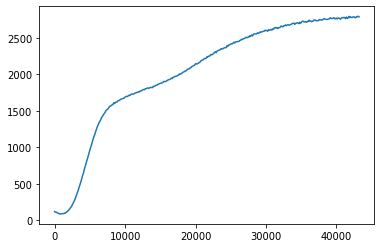

In [8]:
# To plot them against each other
plt.plot(df['Time (s)'], df['F09']); plt.show()